# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


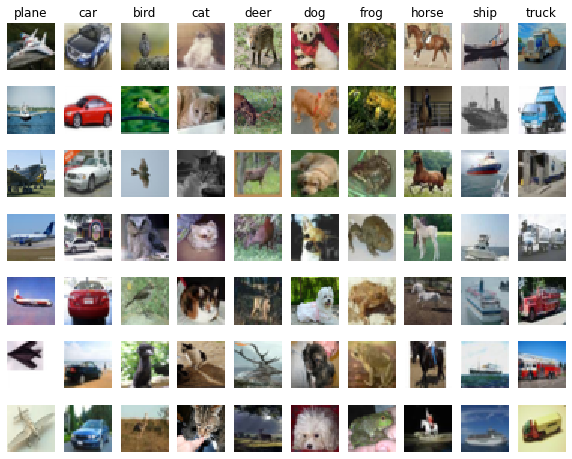

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]  # 从50000训练集取后1000个作为验证集
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]  # 从50000训练集中取前49000个作为训练集
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]  # 从49000训练集中随机取500个作为开发集
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]  # 从10000测试集中取前1000个作为测试集
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
dev data shape:  (500, 32, 32, 3)
dev labels shape:  (500,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


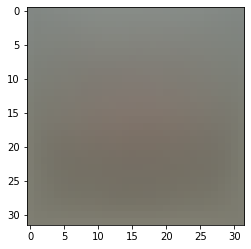

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)  # 根据训练集计算图像mean，axis=0表示对所有图像求均值
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])  # 水平方向加入一列1，代表bias。在优化时只需要优化权重矩阵W，而不需要优化b
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

这里主要介绍多分类SVM损失函数，而不是SVM

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

- SVM loss 形式: （基于hinge loss折页损失）
$$
L=\dfrac{1}{N}\sum\limits_{i=1}^{N}L_i + \lambda R(W)  \\

\color{red}{L_i = \sum\limits_{j\ne y_i} \max\left(0, s_j-s_{y_i}+1\right).\ s_j=w_j^Tx_i,\ s_{y_i}=w_{y_i}^Tx_i}
$$

损失函数的意义在于量化不同的错误有多坏。

- 函数微分：
$$
\begin{aligned}
\nabla_{w_{y_i}} L_i& = -\left(\sum\limits_{j\ne y_i} \mathbb{I}\left(s_j-s_{y_i}+\Delta >0 \right) \right)x_i + \lambda\cdot\nabla_{w_{y_i}} R  \\
\nabla_{w_j} L_i& = \left(\sum\limits_{j\ne y_i} \mathbb{I}\left(s_j-s_{y_i}+\Delta >0 \right) \right)x_i + \lambda\cdot\nabla_{w_j} R \end{aligned}
$$

从数学上计算出最陡峭的方向。这个方向就是损失函数的梯度（gradient）。

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss))  # 随机初始化时,loss约为C-1=9

loss: 9.150865


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)  # gradcheck 梯度检查：使用数值梯度验证解析梯度

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
print("####### regularization on #######")
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -21.483819 analytic: -21.483819, relative error: 8.717650e-12
numerical: 6.291119 analytic: 6.291119, relative error: 2.846282e-11
numerical: -6.825602 analytic: -6.825602, relative error: 4.223147e-11
numerical: -5.657107 analytic: -5.657107, relative error: 6.738661e-11
numerical: -5.567255 analytic: -5.567255, relative error: 4.576263e-11
numerical: 1.152340 analytic: 1.152340, relative error: 1.525865e-10
numerical: 13.295584 analytic: 13.295584, relative error: 2.181095e-11
numerical: -34.479493 analytic: -34.479493, relative error: 1.875506e-12
numerical: 18.763135 analytic: 18.763135, relative error: 1.057778e-11
numerical: 13.245423 analytic: 13.245423, relative error: 1.906763e-11
####### regularization on #######
numerical: -0.862201 analytic: -0.862201, relative error: 6.842970e-11
numerical: -0.485070 analytic: -0.485070, relative error: 2.032185e-10
numerical: 34.242594 analytic: 34.242594, relative error: 2.684254e-12
numerical: -18.335401 analytic: -18.335401,

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ 因为程序中使用了max函数，而max函数在0处不可导，因此可能导致梯度计算值与实际值在0处不一样。但是这种情况不用担心，因为在0处的概率很小，而且即使出现了这种情况，也不会影响最终的结果。

In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))  # 比较数值梯度和解析梯度计算loss的差异

Naive loss: 9.150865e+00 computed in 0.102533s
Vectorized loss: 9.150865e+00 computed in 0.006126s
difference: 0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')  # 计算两个矩阵的Frobenius范数，即矩阵元素平方和的平方根
print('difference: %f' % difference)  # 比较数值梯度和解析梯度计算grad的差异

Naive loss and gradient: computed in 0.104424s
Vectorized loss and gradient: computed in 0.004000s
difference: 0.000000


### Stochastic Gradient Descent （使用SGD优化SVM loss）

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

梯度下降指的是使得损失函数下降，而不是梯度本身下降

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)  # 训练线性分类器，以SVM loss为损失函数，使用SGD优化
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 778.463957
iteration 100 / 1500: loss 284.108223
iteration 200 / 1500: loss 106.352661
iteration 300 / 1500: loss 41.939927
iteration 400 / 1500: loss 18.959968
iteration 500 / 1500: loss 10.473835
iteration 600 / 1500: loss 7.035880
iteration 700 / 1500: loss 5.777470
iteration 800 / 1500: loss 5.916038
iteration 900 / 1500: loss 5.280572
iteration 1000 / 1500: loss 6.159891
iteration 1100 / 1500: loss 5.313290
iteration 1200 / 1500: loss 5.119852
iteration 1300 / 1500: loss 5.387257
iteration 1400 / 1500: loss 5.362761
That took 5.099312s


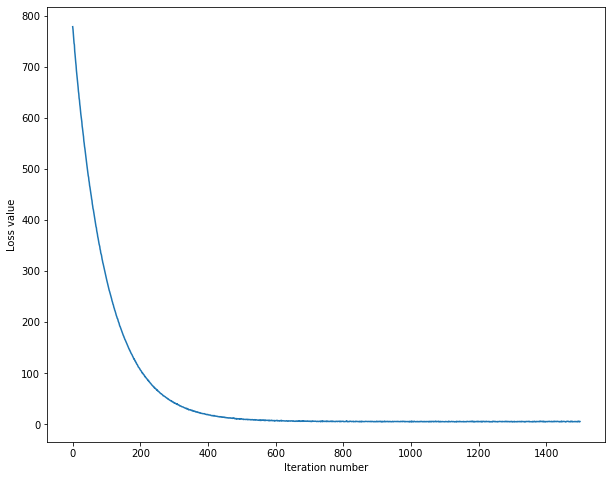

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369286
validation accuracy: 0.372000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-6, 5e-5]
regularization_strengths = [2.5e4, 5e4, 1e5]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
pass
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 797.522854
iteration 100 / 1500: loss 289.169623
iteration 200 / 1500: loss 108.350626
iteration 300 / 1500: loss 42.451383
iteration 400 / 1500: loss 18.586742
iteration 500 / 1500: loss 10.704188
iteration 600 / 1500: loss 6.574750
iteration 700 / 1500: loss 6.453569
iteration 800 / 1500: loss 5.239426
iteration 900 / 1500: loss 5.753142
iteration 1000 / 1500: loss 5.150980
iteration 1100 / 1500: loss 5.183661
iteration 1200 / 1500: loss 5.056328
iteration 1300 / 1500: loss 5.466478
iteration 1400 / 1500: loss 5.448989
iteration 0 / 1500: loss 1566.804147
iteration 100 / 1500: loss 212.506375
iteration 200 / 1500: loss 32.954871
iteration 300 / 1500: loss 9.950688
iteration 400 / 1500: loss 6.405444
iteration 500 / 1500: loss 5.694322
iteration 600 / 1500: loss 5.711012
iteration 700 / 1500: loss 5.372543
iteration 800 / 1500: loss 5.810316
iteration 900 / 1500: loss 6.115123
iteration 1000 / 1500: loss 6.011262
iteration 1100 / 1500: loss 5.923175
iteration 

d:\2Codefield\VS_code\python\Learn_Base\cs231n-assignments\assignment1\cs231n\classifiers\linear_svm.py:92: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\2Codefield\VS_code\python\Learn_Base\cs231n-assignments\assignment1\cs231n\classifiers\linear_svm.py:92: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 1568.645063
iteration 100 / 1500: loss 4228829123794637996929645074458039606641856346822754247910389418205876757183923362654778751745746362648567513101466735738880.000000
iteration 200 / 1500: loss 10919893489369072439670608779603116630930550353210723480418936547034742118698282125778396625874558911304844398247655397841000036837353556429175423612503505735018048345848855627417734383353271981213142270861283598356941195434626727520515265658880.000000
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf


d:\2Codefield\VS_code\python\Learn_Base\cs231n-assignments\assignment1\cs231n\classifiers\linear_svm.py:113: RuntimeWarning: overflow encountered in multiply
  dW += reg * 2 * W


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3094.462474
iteration 100 / 1500: loss 220253057816261632092431220122026468228148963356962225757423101923700823348806371971321402579870682879563701531137271612615287399921943405880384872170592549778775705661113888891425185221629181952.000000
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


d:\2Codefield\VS_code\python\Learn_Base\cs231n-assignments\assignment1\cs231n\classifiers\linear_svm.py:88: RuntimeWarning: invalid value encountered in subtract
  margins = scores - correct_class_scores + delta  # [N, C]


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367265 val accuracy: 0.385000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.358102 val accuracy: 0.371000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.345000 val accuracy: 0.364000
lr 5.000000e-06 reg 2.500000e+04 train accuracy: 0.211816 val accuracy: 0.209000
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.150490 val accuracy: 0.160000
lr 5.000000e-06 reg 1.000000e+05 train accuracy: 0.127449 val accuracy: 0.106000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.082878 val accuracy: 0.085000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.100265 val accuracy: 0.087000
lr 5.0

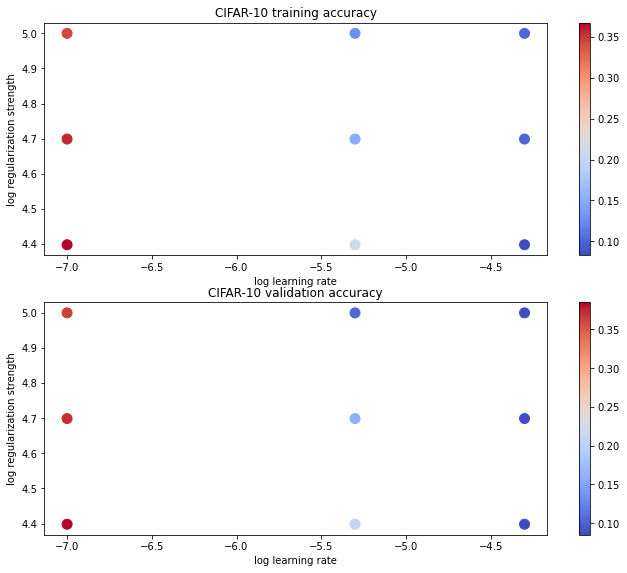

In [15]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)  # 设置子图间距
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [16]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.359000


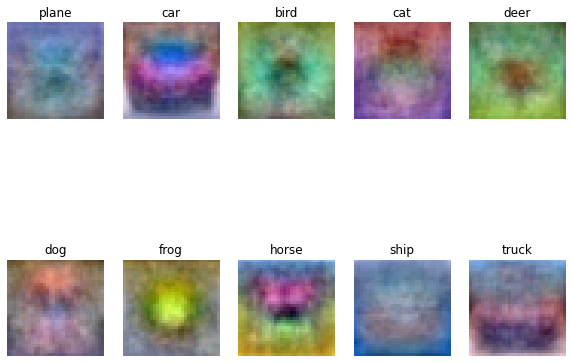

In [17]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
# 可视化权重矩阵
w = best_svm.W[:-1,:] # strip out the bias (去掉bias -> [3072, 10])
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)  # 将权重矩阵归一化到0~255
    plt.imshow(wimg.astype('uint8'))  # 将权重矩阵转为uint8图像
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ 每一类的权重可视化，都大致呈现出了该类物体的背景颜色和形状。

例如飞机权重，呈现了飞机图片的背景蓝色（天空为蓝色）；汽车权重，呈现了汽车图片的形状；鹿和马的权重，呈现了鹿和马的形状（由于多张图片的马朝向不同，因此仿佛是双头马）；青蛙权重，呈现了青蛙图片的颜色。

因为权重可视化图片可被视为每类物体的模板，用于识别该类物体。
